## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that I get some practice working with the difficulties of these concepts. In this project, I will be working to understand the results of an A/B test run on the website of a hypothetical e-commerce company. The goal is to help the company understand if they should roll out a new website homepage, keep the old homepage, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, I import relevant libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.shape[0]

294478

In [4]:
len(df.user_id.unique())

290584

In [5]:
# finding the proportion of converted users
print(len(df[df["converted"] == 1])/len(df))

0.11965919355605512


In [6]:
# finding the number of times the new_page and treatment don't line up
mismatch =  df[(df["group"] == "treatment") != (df["landing_page"] == "new_page")]
mismatch.shape[0]

3893

In [7]:
# checking for data completeness
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, I cannot be sure if this row truly received the new or old page.  

In [8]:
# creating a new dataframe with the correct alignments
df2 = df[(df["group"] == "treatment") == (df["landing_page"] == "new_page")]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

#### Summary Stats for new dataframe

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [11]:
# number of unique user ids
df2.user_id.nunique()

290584

In [12]:
# finding duplicated datapoints
df2.user_id.duplicated().sum()

1

In [13]:
duplicate = df2[df2.user_id.duplicated()]
duplicate

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [14]:
# deleting this duplicate
df2.drop([2893], inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


#### Probabilities for new dataframe

In [16]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [17]:
# probability of an individual converting regardless of the page they receive
print(len(df2[df2["converted"] == 1])/len(df2))

0.11959708724499628


In [18]:
# probability an individual converted given that they were in the control group
control = df2[df2["group"] == "control"]
p_old_data = len(control[control["converted"] == 1])/len(control)
p_old_data

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
# probability an individual converted given that they were in the treatment group
treatment = df2[df2["group"] == "treatment"]
p_new_data = len(treatment[treatment["converted"] == 1])/len(treatment)
p_new_data

0.11880806551510564

In [20]:
# probability that an individual received the new page
print(len(df2[df2["landing_page"] == "new_page"])/len(df2))

0.5000619442226688


From the numbers below, about an equal number of customers were in both the control group. Ideally, the treatment group (who apparently, all landed on the new page) should have a large number (or prorportion) of customers who ended up converting. From the numbers above, it turns out that a lower proportion of customers in the treatment group converted as against the customers in the control group. Therefore, I think there is enough evidence to say that the new treatment page didn't lead to more conversions.

In [21]:
diff = p_new_data - p_old_data
diff

-0.0015782389853555567

In [22]:
len(control)

145274

In [23]:
len(treatment)

145310

<a id='ab_test'></a>
### Part II - A/B Test

Because of the time stamp associated with each event, I could technically run a hypothesis test continuously as each observation was observed. However, the hard question is do I stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do I run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


For now, I assume I need to make the decision just based on all the data I have. Below are my hypotheses based on the assumption that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. My hypotheses are stated in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages respectively.


$p_{new} \leq p_{old}$\
$p_{new} > p_{old}$





I assume that under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br>

Here, I use a sample size for each page equal to the ones in **ab_data.csv**. I perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

In [24]:
# convert rate for p_new under the null
p_new = len(df[df["converted"] == 1])/len(df)
p_new

0.11965919355605512

In [25]:
# convert rate for p_old under the null
p_old = len(df[df["converted"] == 1])/len(df)
p_old

0.11965919355605512

In [26]:
# individuals in the treatment group
n_new = len(treatment)
n_new

145310

In [27]:
# individuals in the treatment group
n_old = len(control)
n_old

145274

Here, I simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null. I store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [28]:
new_page_converted = np.random.choice([0,1], size = n_new, p = [1-p_new, p_new])
new_page_converted.mean()

0.11928291239419173

Here, I simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null. I store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [29]:
old_page_converted = np.random.choice([0,1], size = n_old, p = [1-p_old, p_old])
old_page_converted.mean()

0.11799083111912662

Here, I find $p_{new}$ - $p_{old}$ for your simulated values above.

In [30]:
new_page_converted.mean() - old_page_converted.mean() 

0.00129208127506511

Here, I perform bootstrapping 10,000 times with these new samples. I store all 10,000 values in a numpy array called **p_diffs**.

In [31]:
p_diffs = []

for _ in range(10000):
    new = pd.DataFrame(new_page_converted).sample(n_new, replace = True).mean()
    old = pd.DataFrame(old_page_converted).sample(n_old, replace = True).mean()
    p_diffs.append(new - old)
    
p_diffs = np.array(p_diffs)

Here, I plot a histogram of the **p_diffs**.

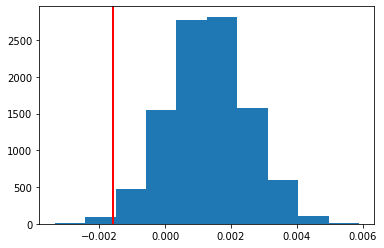

In [32]:
plt.hist(p_diffs);
plt.axvline(x=diff, color = "r", linewidth = 2);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [33]:
# calculating the proportion of p_diffs that is greater than the actual difference observed in ab_data.csv
p_diffs_greater = p_diffs[p_diffs > diff]
p_value = len(p_diffs_greater)/len(p_diffs)
p_value

0.9909

**The value I just calculated in j is the `P-value`. It denotes the probability of obtaining my statistic (difference in means) if my null hypothesis is true. Technically, it is proportion of null values that are considered extreme based on my alternative hypothesis. This means there is no difference between the new and old pages. Conclusively, based on the data, I don't have enough evidence to reject the null hypothesis. Therefore, I fail to reject the null hypothesis**

Here, I explore using built-in functions to achieve similar results. Though using the built-in's is easier to code, all I did up to this point was solidify the ideas that are critical to correctly thinking about statistical significance. 

#### Using Built-in Functions for Hypothesis Testing, Bootstrapping and A/B Tests

Next, I calculate the number of conversions for each page, as well as the number of individuals who received each page.
`n_old` and `n_new` refer to the number of rows associated with the old page and new page, respectively. I'd use the `statsmodels` module.

In [34]:
import statsmodels.api as sm

convert_old = control[control["converted"] == 1]
convert_new = treatment[treatment["converted"] == 1]
n_old = len(control)
n_new = len(treatment)

Now, I use `stats.proportions_ztest` to compute my test statistic and p-value.  [This](http://knowledgetack.com/python/statsmodels/proportions_ztest/) was really helpful in understanding how the built-in's worked.

In [35]:
from statsmodels.stats.proportion import proportions_ztest
proportions_ztest(len(convert_old) + len(convert_new), len(df2), value = len(convert_old) , alternative = "larger")

(-29053390.40815725, 1.0)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-score and p-value gotten from the cell above means that individuals are as likely to convert irrespective of what page is shown to them. They agree with the findings when built-in functions were not used**


<a id='regression'></a>
### Part III - A regression approach

Here, I want to explore how the results gotten in the previous A/B test can also be acheived by regression. Since each row is either a conversion or no conversion, I use Logistic Regression. I use **statsmodels** to fit a logistic regression model to see if there is a significant difference in conversion based on which page a customer receives.  However, I first need to create a column for the intercept, and create a dummy variable column for which page each user received. I also have to add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
df2["intercept"] = 1
df2[["control", "ab_page"]] = pd.get_dummies(df2["group"])
del df2["control"]
df2.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


Here, I use **statsmodels** to import my logistic regression model. I instantiate the model, and fit the model using the two columns I created above to predict whether or not an individual converts.

In [37]:
import statsmodels.api as sm
log_mod = sm.Logit(df2["converted"], df2[["intercept", "ab_page"]])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [38]:
# model summary
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2020-05-14 23:31 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [39]:
# categorical variable intepretation
np.exp(-0.0150)

0.9851119396030626

**From the regression model, the p-value associated with `ab_page` is 0.1899. The p_value obtained from my regression model is 0.1899. For regression models, a p-value of < 0.05 means there is a statistically significant relationship between the explanatory variable and the response variable. In this case, it means there is no statistically significant relationship between showing people the new page versus showing them the old page and people converting. The p-value gotten here differs from that gotten from the hypothesis testing because of the differences in how the hypotheses were stated for both cases. Here, we took an individualistic approach to determining whether or not individuals converted based on the type of landing page they're shown. However, in the hypothesis testing, what we did was first set the null to be true (i.e. showing individuals the new page, at best, has as much effect on making them convert, as showing them the old page). We then concluded, based on the data we had, that that hypothesis is indeed true. This means we took an aggregate approach to making our conclusions. Also, from the `ab_page` coefficient of 0.95, we see that customers who were shown the new page are 0.985 times as likely to convert as customers who were shown the old page. This represents a lower performance metric. So, we can conclude that the sticking to the old page is just fine for the company.**

### Further Exploration

Now, I consider other things that might influence whether or not an individual converts.

1. Is it a good idea to add other factors to the regression model?  
2. Are there any disadvantages to adding additional terms into my regression model?

**There is no absolute truth as to whether or not considering other factors would help more concrete conclusions. I, however, need to make certain that these new factors have no relationship between eachother. If they did, they will have high variance inflation factors. This would lead to flipped relationships in my multiple regression model from what I would expect if I just considered the relationships in their corresponding bivariate regression models (i.e. relationship between each of these factors and the response variable). Also, even if these factors are unrelated, I can still overfit our model. The consequence is that I will not be able to generalize conclusions (i.e. I will not be able to draw causations from the entire population). On the flip side, considering just one factor would terribly underfit my model and would have the same consequences as overfitting it.**

Asides testing if the conversion rate changes for different pages, I add an effect based on which country a user lives. 

In [40]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
print(df_new.country.value_counts())
df_new.head()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64


,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [41]:
# create the necessary dummy variables, fit a logit model and display the results
df_new[["CA", "UK", "US"]] = pd.get_dummies(df_new["country"])
del df_new["UK"]
log_mod2 = sm.Logit(df_new["converted"], df_new[["intercept", "US", "CA"]])
results = log_mod2.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2020-05-14 23:31 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9868    0.0114  -174.1736  0.0000  -2.0092  -1.9645
US           -0.0099    0.0133    -0.7458  0.4558  -0.0360   0.0161
CA           -0.0507    0.0284    -1.7863  0.0740  -0.1064   0.0049
==================================================================

"""

In [42]:
# categorical intepretations
np.exp(-0.0099), np.exp(-0.0507)

(0.9901488436829572, 0.9505637969004034)

**Here, I see that all things being held constant, a customer in the US is 0.99 times as likely to convert as a customer in the UK. Also, a customer in Canada is 0.95 times as likely to convert as a customer in the UK.**

What I did above was loo at how individual factors of country affected conversion. Now, I consider an interaction between page and country to see if there are significant effects on conversion.

In [43]:
# fit an MLR model and obtain the results
log_mod2 = sm.Logit(df_new["converted"], df_new[["intercept", "ab_page", "US", "CA"]])
results = log_mod2.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2020-05-14 23:31 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9794    0.0127  -155.4145  0.0000  -2.0044  -1.9544
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
US           -0.0099    0.0133    -0.7433  0.4573  -0.0359   0.0162
CA           -0.0506    0.0284    -1.7835  0.0745  -0.1063   0.0050
==================================================================

"""

In [44]:
np.exp(-0.0149),np.exp(-0.0099), np.exp(-0.0506)

(0.9852104557227469, 0.9901488436829572, 0.9506588580330708)

**Here, we see that all things being held constant, a customer in US is 0.99 times as likely to convert as a customer in the UK. Also, a customer in Canada is 0.95 times as likely to convert as a customer in the UK. Also, a customer that was shown the new page is 0.98 times as likely to convert as a customer that was shown the old page.**